### Tissue Masks - Experiment 1
DHR preprocessed, @1024px

In [1]:
from tiatoolbox.models.engine.semantic_segmentor import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.tools.registration.wsi_registration import match_histograms, DFBRegister
from tiatoolbox.utils.misc import imread
import os
import cv2
import numpy as np
from scipy import ndimage
import SimpleITK as sitk
from matplotlib import pyplot as plt
from skimage import color, exposure, measure, morphology

|2023-09-06|07:49:43.203| [WARNING] /home/ivan/miniconda3/envs/tiatoolbox-dev/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()

|2023-09-06|07:49:43.203| [WARNING] /home/ivan/miniconda3/envs/tiatoolbox-dev/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details

In [33]:
ON_GPU = True
SOURCE_PATH = "/data/ANHIR_Parsed_1024/"
TARGET_PATH = "/data/ANHIR_Masks_1024/"
SAMPLE_ID = "0"
SAMPLE_PATH = os.path.join(SOURCE_PATH, SAMPLE_ID)
SAMPLE_TARGET_PATH = os.path.join(TARGET_PATH, SAMPLE_ID)
SOURCE_IMAGE_PATH = os.path.join(SAMPLE_PATH, "source.jpg")
TARGET_IMAGE_PATH = os.path.join(SAMPLE_PATH, "target.jpg")

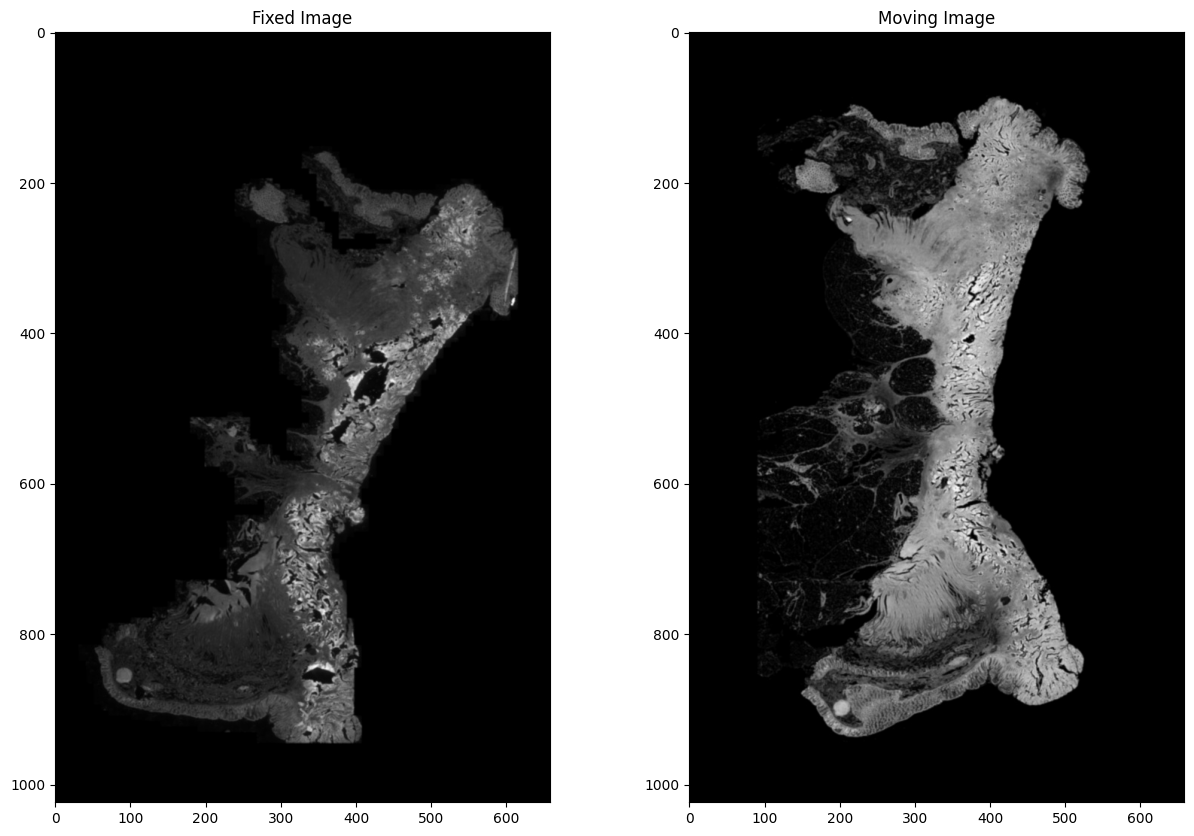

In [34]:
fixed_image_rgb = imread(SOURCE_IMAGE_PATH)
moving_image_rgb = imread(TARGET_IMAGE_PATH)

_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_image_rgb, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image_rgb, cmap='gray')
axs[1].set_title("Moving Image")
plt.show()

In [35]:
def preprocess_image(image):
  image = color.rgb2gray(image)
  image = exposure.rescale_intensity(image, in_range=tuple(np.percentile(image, (0.5, 99.5))))
  image = image*255
  return image.astype(np.uint8)

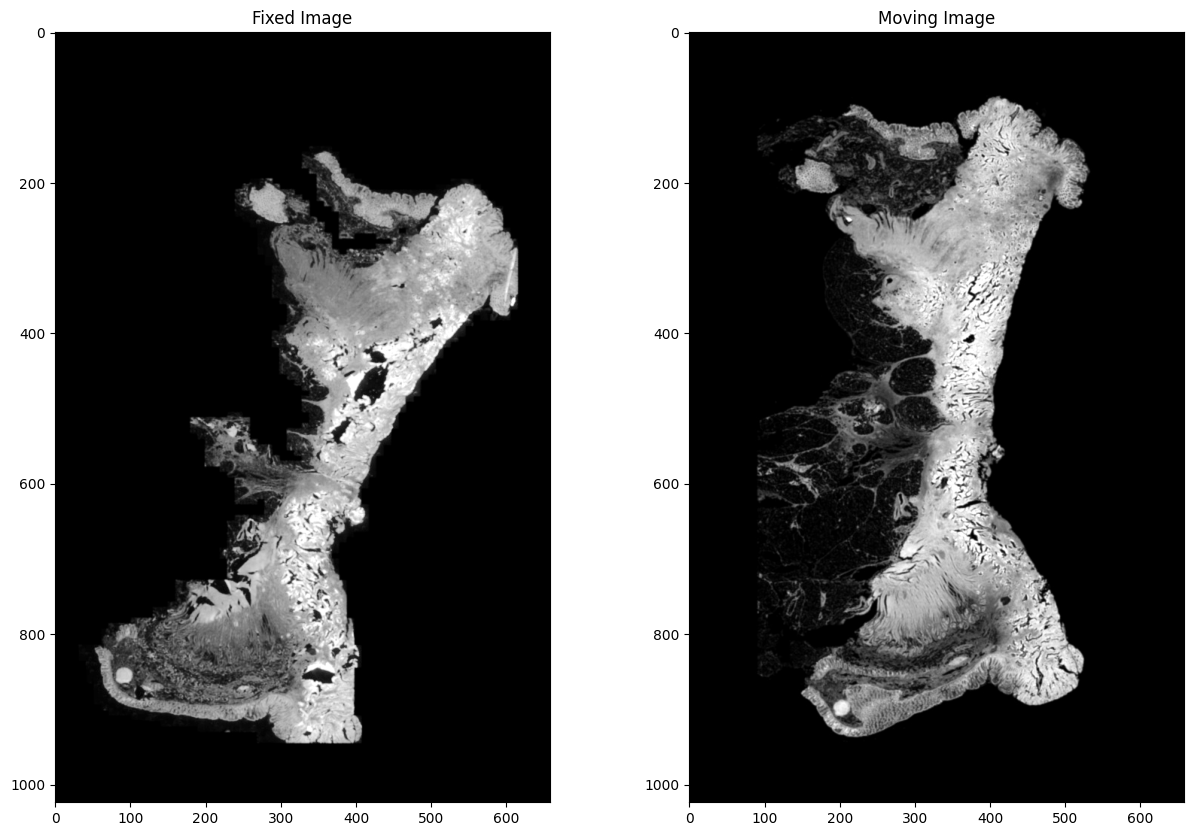

True

In [36]:
fixed_image = preprocess_image(fixed_image_rgb)
moving_image = preprocess_image(moving_image_rgb)
fixed_image, moving_image = match_histograms(fixed_image, moving_image)

_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_image, cmap='gray')
axs[0].set_title("Fixed Image")
axs[1].imshow(moving_image, cmap='gray')
axs[1].set_title("Moving Image")
plt.show()

if not os.path.exists(SAMPLE_TARGET_PATH):
  os.makedirs(SAMPLE_TARGET_PATH)

temp = np.repeat(np.expand_dims(fixed_image, axis=2), 3, axis=2)
cv2.imwrite(os.path.join(SAMPLE_TARGET_PATH, 'source.png'), temp)
temp = np.repeat(np.expand_dims(moving_image, axis=2), 3, axis=2)
cv2.imwrite(os.path.join(SAMPLE_TARGET_PATH, 'target.png'), temp)

In [37]:
segmentor = SemanticSegmentor(
	pretrained_model="unet_tissue_mask_tsef",
	num_loader_workers=4,
	batch_size=4,
)

output = segmentor.predict(
  [SOURCE_IMAGE_PATH, TARGET_IMAGE_PATH],
	save_dir=os.path.join(SAMPLE_TARGET_PATH, "masks"),
	mode="tile",
	resolution=1.0,
	units="baseline",
	patch_input_shape=[1024, 1024],
	patch_output_shape=[512, 512],
	stride_shape=[512, 512],
	on_gpu=ON_GPU,
	crash_on_exception=True,
)

|2023-09-06|08:08:48.573| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.


Download from https://tiatoolbox.dcs.warwick.ac.uk/models/registration/UNET-v0.0-TSEF.pth
Save to /home/ivan/.tiatoolbox/models/UNET-v0.0-TSEF.pth


|2023-09-06|08:08:48.919| [WARNING] WSIPatchDataset only reads image tile at `units="baseline"`. Resolutions will be converted to baseline value.
|2023-09-06|08:08:48.925| [WARNING] Raw data is None.
|2023-09-06|08:08:48.925| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch: 100%|##############################| 1/1 [00:01<00:00,  1.26s/it]

|2023-09-06|08:08:50.189| [INFO] Finish: 0
|2023-09-06|08:08:50.189| [INFO] --Input: /data/ANHIR_Parsed_1024/0/source.jpg
|2023-09-06|08:08:50.190| [INFO] --Output: /data/ANHIR_Masks_1024/0/masks/0



|2023-09-06|08:08:50.195| [WARNING] Raw data is None.
|2023-09-06|08:08:50.195| [WARNING] Unknown scale (no objective_power or mpp)
Process Batch: 100%|##############################| 1/1 [00:00<00:00,  1.96it/s]

|2023-09-06|08:08:50.710| [INFO] Finish: 0
|2023-09-06|08:08:50.710| [INFO] --Input: /data/ANHIR_Parsed_1024/0/target.jpg
|2023-09-06|08:08:50.710| [INFO] --Output: /data/ANHIR_Masks_1024/0/masks/1


In [38]:
def post_processing_mask(mask):
  mask = ndimage.binary_fill_holes(mask, structure=np.ones((3,3))).astype(int)

  # remove all the objects while keep the biggest object only
  label_img = measure.label(mask)
  if len(np.unique(label_img)) > 2:
    regions = measure.regionprops(label_img)
    mask = mask.astype(bool)
    all_area = [i.area for i in regions]
    second_max = max([i for i in all_area if i != max(all_area)])
    mask = morphology.remove_small_objects(mask, min_size=second_max + 1)
  return mask.astype(np.uint8)

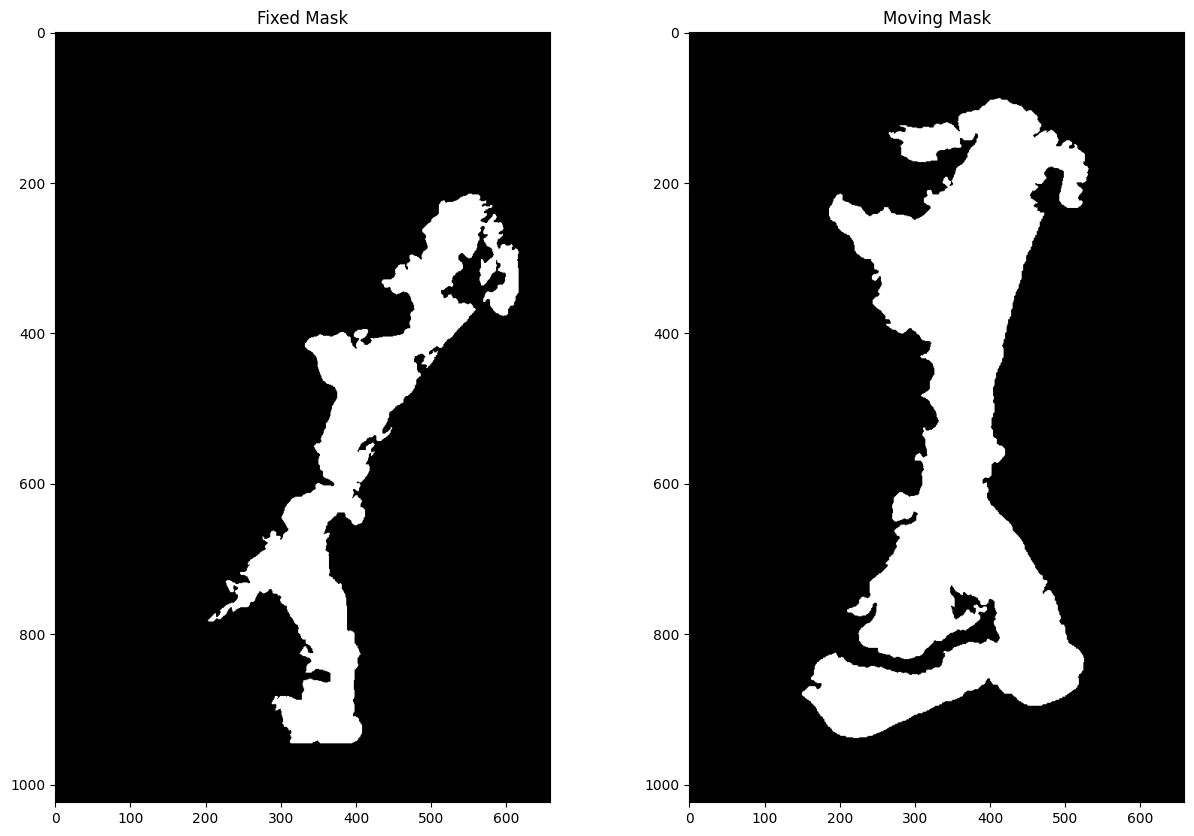

In [39]:
fixed_mask = np.load(output[0][1] + ".raw.0.npy")
moving_mask = np.load(output[1][1] + ".raw.0.npy")

# Simple processing of the raw prediction to generate semantic segmentation task
fixed_mask = np.argmax(fixed_mask, axis=-1) == 2 
moving_mask = np.argmax(moving_mask, axis=-1) == 2  

fixed_mask = post_processing_mask(fixed_mask)
moving_mask = post_processing_mask(moving_mask)

_, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(fixed_mask, cmap='gray')
axs[0].set_title("Fixed Mask")
axs[1].imshow(moving_mask, cmap='gray')
axs[1].set_title("Moving Mask")
plt.show()